# Exploratory Data Analysis

In [1]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

from skgstat import Variogram
import geopandas as gpd

import plotly.express as px
import plotly.graph_objects as go

import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine

# Make this example reproducible
np.random.seed(123)

plt.style.use('ggplot')
px.defaults.height = 400; px.defaults.width = 620
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (6, 6), 'axes.grid': False})

## Obtain Train & Test Data

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

# consider 2011-2020 data first
url_list = [
    # "https://testground.s3.ap-southeast-1.amazonaws.com/3537ea83-529f-471b-92ef-bef6095bb850/1961-1990.csv",
    # "https://testground.s3.ap-southeast-1.amazonaws.com/3537ea83-529f-471b-92ef-bef6095bb850/1991-2000.csv",
    # "https://testground.s3.ap-southeast-1.amazonaws.com/3537ea83-529f-471b-92ef-bef6095bb850/2001-2010.csv",
    "https://testground.s3.ap-southeast-1.amazonaws.com/3537ea83-529f-471b-92ef-bef6095bb850/2011-2020.csv"
    ]

df_list = (pd.read_csv(file) for file in url_list)

df   = pd.concat(df_list, ignore_index=True)

X = df[['Latitude', 'Longitude']]  # Features: coordinates
y = df['Tave_wt']  # Target variable: temp average during winter

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [3]:
X_train.shape

(151, 2)

## Basic Statistics Plot

### Assumption 1. Your data has a normal distribution

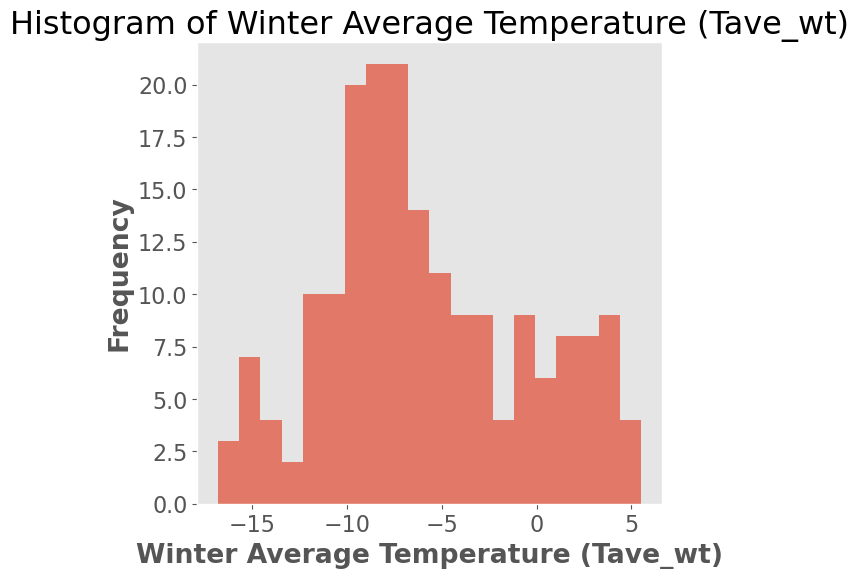

In [4]:
# check if the tave_wt is normally distributed
plt.hist(df['Tave_wt'], bins=20, alpha=0.7)

plt.xlabel('Winter Average Temperature (Tave_wt)')
plt.ylabel('Frequency')

plt.title('Histogram of Winter Average Temperature (Tave_wt)')

plt.show()

## Spatial Data Exploration

### All Data

In [5]:
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="Tave_wt",
                        color_continuous_scale="RdYlGn_r",
                        center={"lat": df.Latitude.mean(), "lon": df.Longitude.mean()}, zoom=3.5,
                        mapbox_style="carto-positron", hover_name="Tave_wt")
fig.update_layout(title="Average Temperature During Winter in BC")
fig.update_layout(margin=dict(l=0, r=0, t=30, b=10))
fig.show()

### Training Data

In [6]:
y_train_df = pd.DataFrame(y_train, columns=["Tave_wt"])

train_data = pd.concat([X_train, y_train_df], axis=1)

train_data.shape

(151, 3)

In [7]:

fig = px.scatter_mapbox(train_data, lat="Latitude", lon="Longitude", color="Tave_wt",
                        color_continuous_scale="RdYlGn_r",
                        center={"lat": train_data.Latitude.mean(), "lon": train_data.Longitude.mean()}, zoom=3.5,
                        mapbox_style="carto-positron", hover_name="Tave_wt")
fig.update_layout(title="Average Temperature During Winter in BC")
fig.update_layout(margin=dict(l=0, r=0, t=30, b=10))
fig.show()

## Variogram
- mainly used in geostatistics to describe the spatial geometry of regionalized variables
- defines the variance (autocorrelation structure) as a function of distance

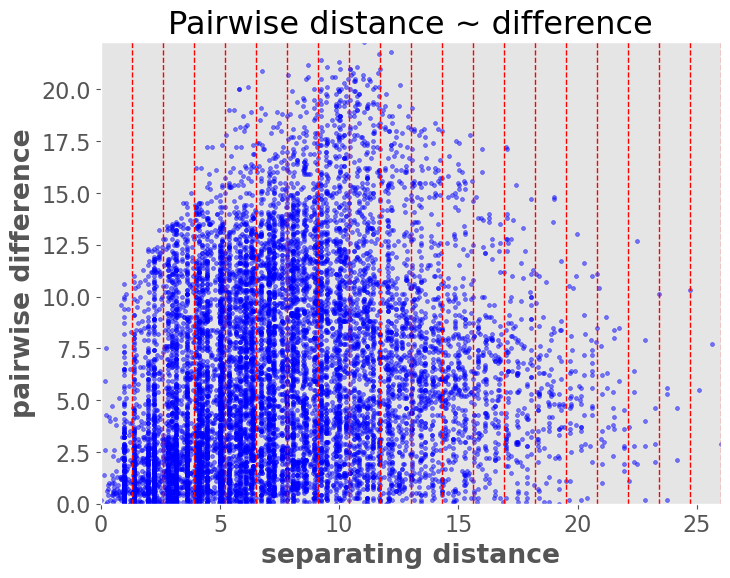

In [8]:
warnings.filterwarnings("ignore")  # Silence some warnings
vario = Variogram(coordinates=train_data[["Latitude", "Longitude"]],
                  values=train_data["Tave_wt"],
                  n_lags=20)
vario.distance_difference_plot();

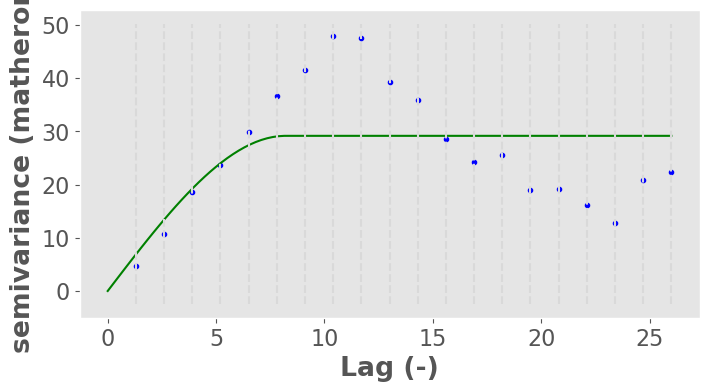

In [9]:
vario.plot(hist=False);

- at small distances (points are close together), sicne points are correlated, the variance is reduced

In [10]:
vario.describe()["effective_range"]

8.205271193094124

# Simple Kriging

In [11]:
resolution = 0.5  # cell size in meters, smaller cell size = smaller pixel = higher resolution 
gridx = np.arange(df.Latitude.min(), df.Latitude.max(), resolution)
gridy = np.arange(df.Longitude.min(), df.Longitude.max(), resolution)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 28.40604017260362
Full Sill: 28.406044696278762
Range: 8.93794603664032
Nugget: 4.5236751407959e-06 



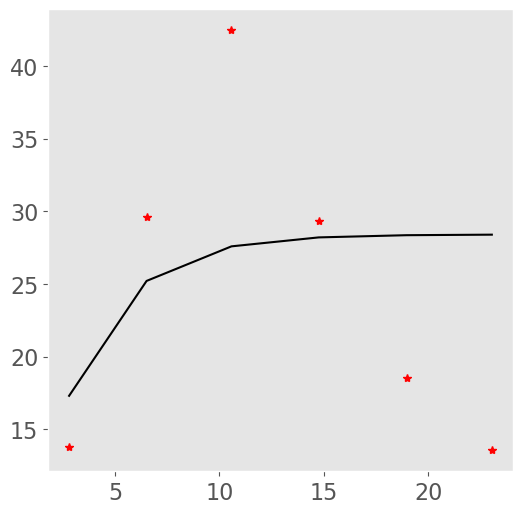

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



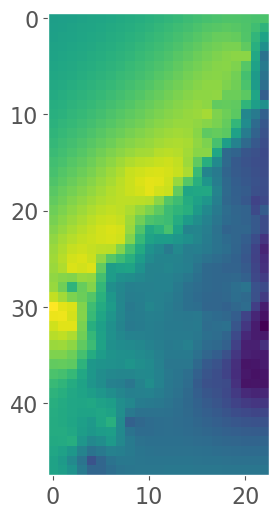

In [12]:
OK = OrdinaryKriging(
    df['Latitude'],
    df['Longitude'],
    df['Tave_wt'],
    variogram_model= "exponential",# "spherical" "linear" "gaussian" "power" "exponential"
    verbose=True,
    enable_plotting=True
)

z, ss = OK.execute("grid", gridx, gridy)

kt.write_asc_grid(gridx, gridy, z, filename="output.asc")
plt.imshow(z)
plt.show()

Text(0, 0.5, 'Y')

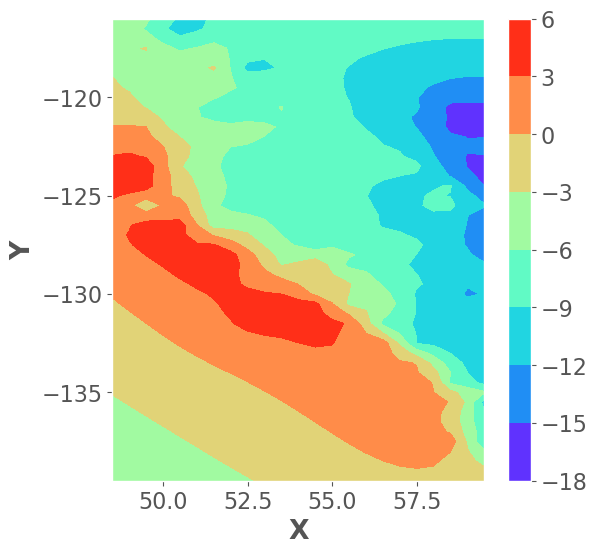

In [13]:
xgrid,ygrid = np.meshgrid(gridx,gridy)

plt.contourf(xgrid, ygrid, z, cmap="rainbow")
plt.colorbar()

plt.xlabel("X")
plt.ylabel("Y")

### Plot Kriging Result on Plotly

In [14]:
import numpy as np
import shapely.geometry as geometry
import itertools
from shapely.geometry import Polygon
import osmnx as ox
def pixel2poly(x, y, z, resolution):
    """
    x: x coords of cell
    y: y coords of cell
    z: matrix of values for each (x,y)
    resolution: spatial resolution of each cell
    """
    polygons = []
    values = []
    half_res = resolution / 2
    for i, j  in itertools.product(range(len(x)), range(len(y))):
        minx, maxx = x[i] - half_res, x[i] + half_res
        miny, maxy = y[j] - half_res, y[j] + half_res
        #polygons.append(Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)]))
        polygons.append(Polygon([(miny, minx), (miny, maxx), (maxy, maxx), (maxy, minx)]))
        if isinstance(z, (int, float)):
            values.append(z)
        else:
            values.append(z[j, i])
    return polygons, values


In [15]:
polygons, values = pixel2poly(gridx, gridy, z, resolution)
tave_model = (gpd.GeoDataFrame({"Tave_wt": values}, geometry=polygons, crs="EPSG:3347")
                 #.to_crs("EPSG:4326")
                 )

In [16]:
fig = px.choropleth_mapbox(tave_model, geojson=tave_model.geometry, locations=tave_model.index,
                           color="Tave_wt", color_continuous_scale="RdYlGn_r", opacity=0.5,
                           center={"lat": train_data.Latitude.mean(), "lon": train_data.Longitude.mean()}, zoom=3.5,
                           mapbox_style="carto-positron")
fig.update_layout(margin=dict(l=0, r=0, t=30, b=10))
fig.update_traces(marker_line_width=1)